# @ Alexander Guschin, 23 October 2014

### Load data

In [3]:
import pandas as pd
from sklearn import ensemble
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/covtype.data')
test['Id'] = range(1, len(test)+1)

In [72]:
train.ix[:0,:11]

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,1,2596,51,3,258,0,510,221,232,148,6279


# 1. Let's take a look at features distribution

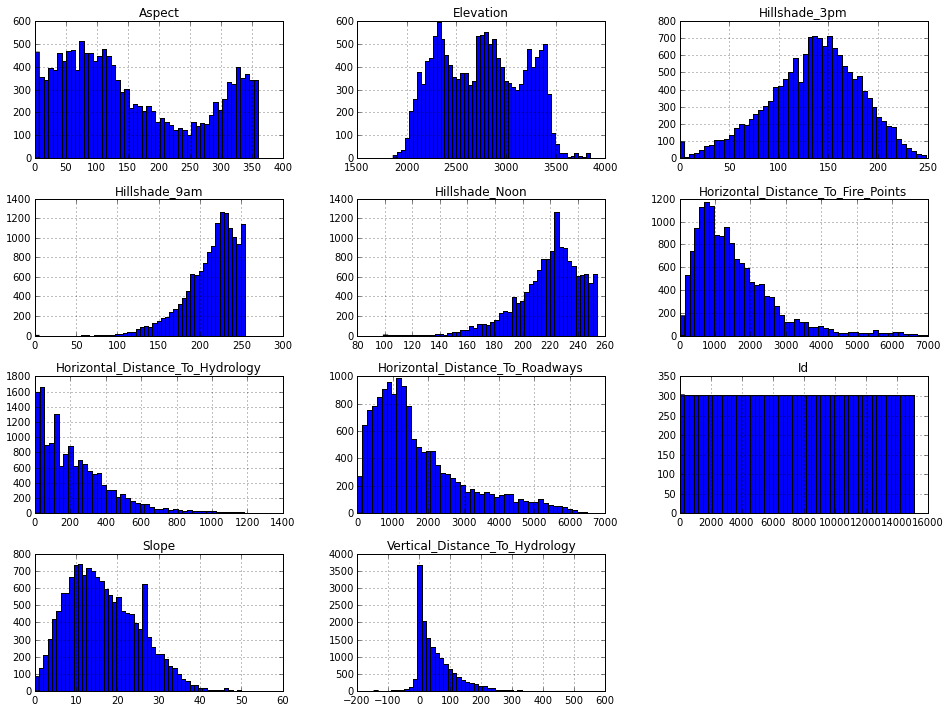

In [73]:
train.ix[:,:11].hist(figsize=(16,12),bins=50)
plt.show()

## As we know about that Aspect is in degrees azimuth, we can try to shift it at 180

In [13]:
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

train['Aspect2'] = train.Aspect.map(r)
test['Aspect2'] = test.Aspect.map(r)

## You can notice that Vertical_Distance_To_Hydrology have some negative values. It may be good idea to create variable which indicates positive or negative value here

In [75]:
train['Highwater'] = train.Vertical_Distance_To_Hydrology < 0
test['Highwater'] = test.Vertical_Distance_To_Hydrology < 0

# 2. Also, It's always a good idea to check if features are related to each other

### Take a look at Elevation and Vertical_Distance_To_Hydrology. Color each cover type in unique color to see some patterns

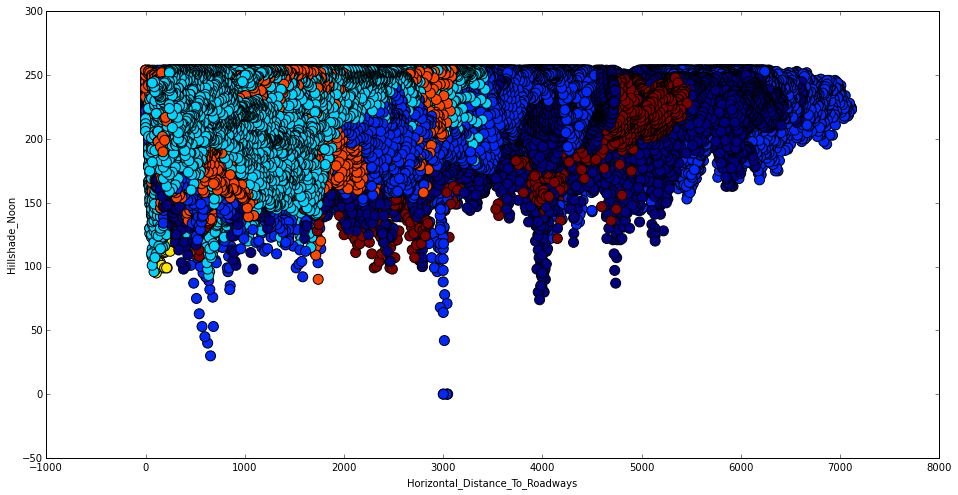

In [27]:
import numpy as np
from IPython.display import Image

def plotc(c1,c2):

    fig = plt.figure(figsize=(16,8))
    sel = np.array(list(train.Cover_Type.values))

    plt.scatter(c1, c2, c=sel, s=100)
    plt.xlabel(c1.name)
    plt.ylabel(c2.name)
    
def plotd(c1,c2):

    fig = plt.figure(figsize=(16,8))
    sel = np.array(list(test.Cover_Type.values))

    plt.scatter(c1, c2, c=sel, s=100)
    plt.xlabel(c1.name)
    plt.ylabel(c2.name)
    
plotd(test.Horizontal_Distance_To_Roadways, test.Hillshade_Noon)

### Now we can create some variable that will have plot a bit simplier (Besides understanding dependencies like this may lead you to some cool features!)

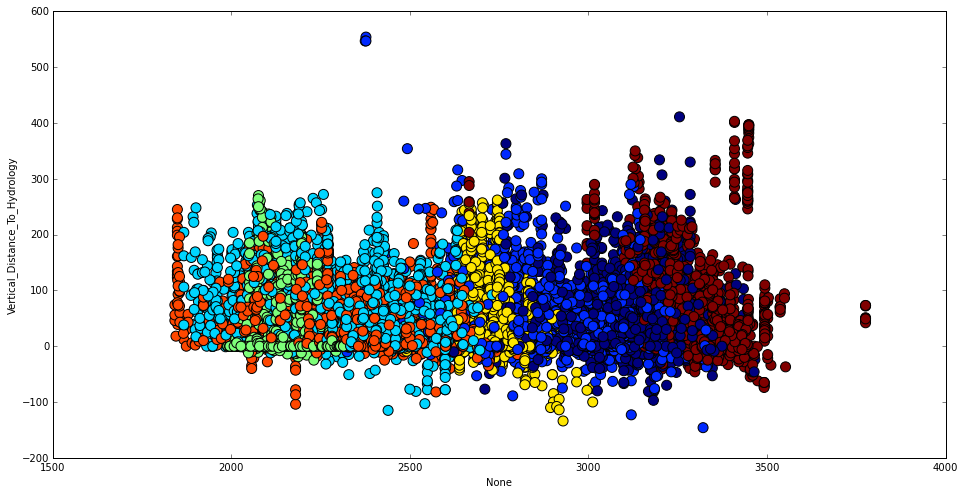

In [77]:
plotc(train.Elevation-train.Vertical_Distance_To_Hydrology, train.Vertical_Distance_To_Hydrology)

### Fine! Now we can add this new feature to train and test (the same goes for Horizontal_Distance_To_Hydrology, you can check this by youself)

In [90]:
train['EVDtH'] = train.Elevation-train.Vertical_Distance_To_Hydrology
test['EVDtH'] = test.Elevation-test.Vertical_Distance_To_Hydrology

train['EHDtH'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2
test['EHDtH'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2

# 3. Finally, we can create some features from those which have similar meanings, f.e. distances

In [80]:
train['Distanse_to_Hydrolody'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
test['Distanse_to_Hydrolody'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']

train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])

train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])

train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])

# 4. Further ideas :)

### Let's take a look at some tricky relations between features

### Here you can see two possible hints: (1) Hillshade_3pm has some values at zero which seems like some data is missing. You can try to replace those zeros with median or try to predict their possible values with random forest. (2) This tricky dependency between Hillshapes means something you probably could use :)

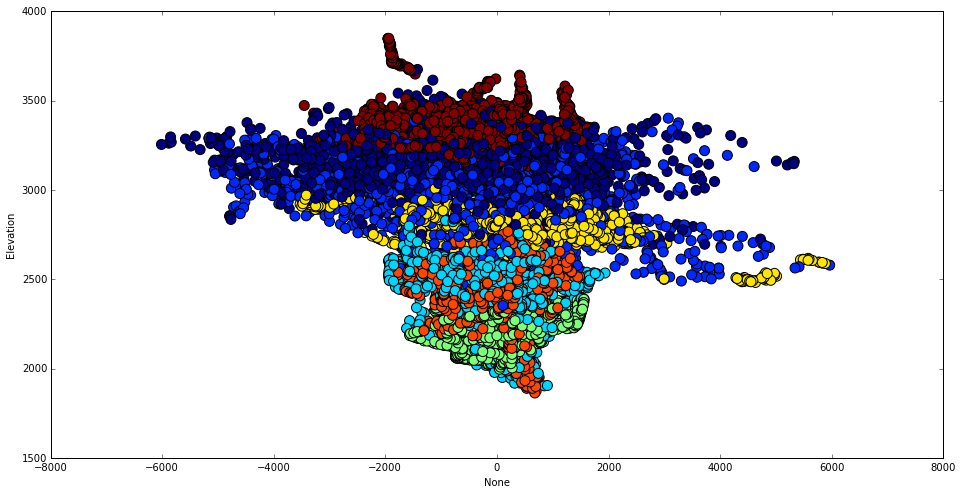

In [33]:
plotc(train.Horizontal_Distance_To_Fire_Points - train.Horizontal_Distance_To_Roadways, train.Elevation)

# 5. Congratulations! Now let's make a submission using all those new features and see if they are useful eventually :)

In [82]:
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]

X_train = train[feature_cols]
X_test = test[feature_cols]
y = train['Cover_Type']
test_ids = test['Id']

forest = ensemble.ExtraTreesClassifier(n_estimators=400, criterion='gini', max_depth=None, 
    min_samples_split=2, min_samples_leaf=1, max_features='auto', 
    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0, 
    min_density=None)

In [83]:
forest.fit(X_train, y)

with open('features_engineering_benchmark.csv', "w") as outfile:
    outfile.write("Id,Cover_Type\n")
    for e, val in enumerate(list(forest.predict(X_test))):
        outfile.write(str(test_ids[e])+","+str(val))

# 6. Finally, let's take a look at features importances to see which features matter more for prediction

### We can see that many of our new features became great addition to existed ones.

In [84]:
pd.DataFrame(forest.feature_importances_,index=X_train.columns).sort([0], ascending=False) [:10]

,0
EVDtH,0.091744
EHDtH,0.088516
Elevation,0.086073
Wilderness_Area4,0.045444
Fire_Road_1,0.035168
Horizontal_Distance_To_Roadways,0.033483
Hydro_Road_2,0.032975
Hydro_Road_1,0.031925
Hydro_Fire_1,0.028631
Distanse_to_Hydrolody,0.028237
